In [2]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from PIL import Image

plt.rcParams['figure.figsize'] = (8, 8)

In [3]:
data_dir = './Person_dataset'

# transforms for the training data and testing data
transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(64),
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform = transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform = transforms)

train_load = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
test_load = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


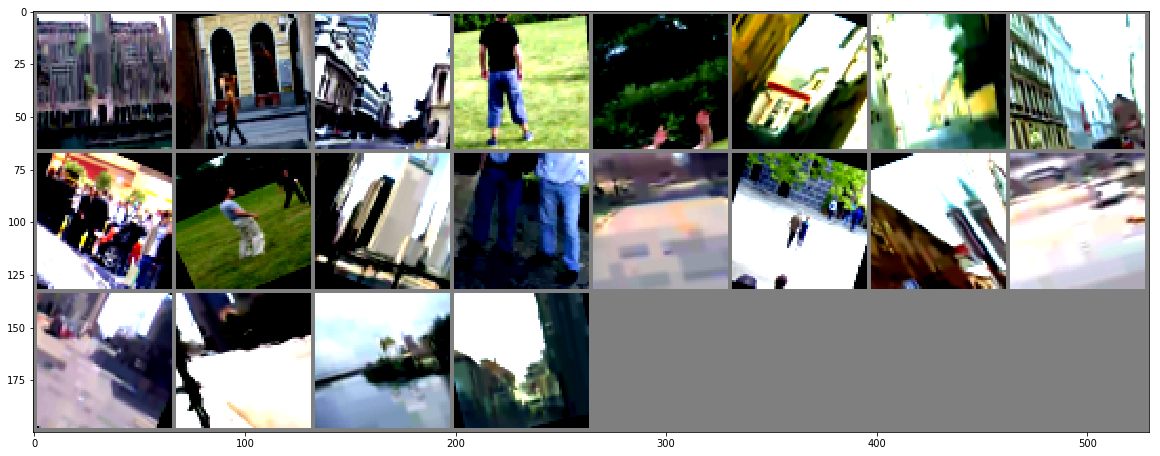

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_load)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [5]:
print('here {} images'.format(len(train_data)))
print('here {} images'.format(len(test_data)))
print('here {} batches'.format(len(train_load)))
print('here {} batches'.format(len(test_load)))

here 1300 images
here 500 images
here 65 batches
here 25 batches


In [6]:

def accuracy(a, b):
    return (a == b).float().mean()

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3,stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)        #Batch normalization
        self.relu = nn.ReLU()                 #RELU Activation
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)   #Maxpooling reduces the size by kernel size. 64/2 = 32
        
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)    #Size now is 32/2 = 16
        
        #Flatten the feature maps. You have 32 feature mapsfrom cnn2. Each of the feature is of size 16x16 --> 32*16*16 = 8192
        self.fc1 = nn.Linear(in_features=8192, out_features=4000)   #Flattened image is fed into linear NN and reduced to half size
        self.droput = nn.Dropout(p=0.5)                    #Dropout used to reduce overfitting
        self.fc2 = nn.Linear(in_features=4000, out_features=2000)
        self.droput = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(in_features=2000, out_features=500)
        self.droput = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(in_features=500, out_features=50)
        self.droput = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(in_features=50, out_features=2)    
        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        #Flattening is done here with .view() -> (batch_size, 32*16*16) = (100, 8192)
        out = out.view(-1,8192)   #-1 will automatically update the batchsize as 100; 8192 flattens 32,16,16
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc5(out)
        return out

In [8]:
model = CNN()

loss_fn = nn.CrossEntropyLoss()        
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [11]:

#Training the CNN

import time

num_epochs = 50

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    
    #Reset these below variables to 0 at the begining of every epoch
    start = time.time()
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.data.item()       # Accumulate the loss
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_data)))
   
    #Testing
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        
        
        outputs = model(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_data)))
    stop = time.time()
    

    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}, Time: {}s'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1], stop-start))

Epoch 1/50, Training Loss: 0.674, Training Accuracy: 65.000, Testing Loss: 0.026, Testing Acc: 76.000, Time: 34.60198402404785s
Epoch 2/50, Training Loss: 0.633, Training Accuracy: 73.000, Testing Loss: 0.025, Testing Acc: 81.000, Time: 34.67836785316467s


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

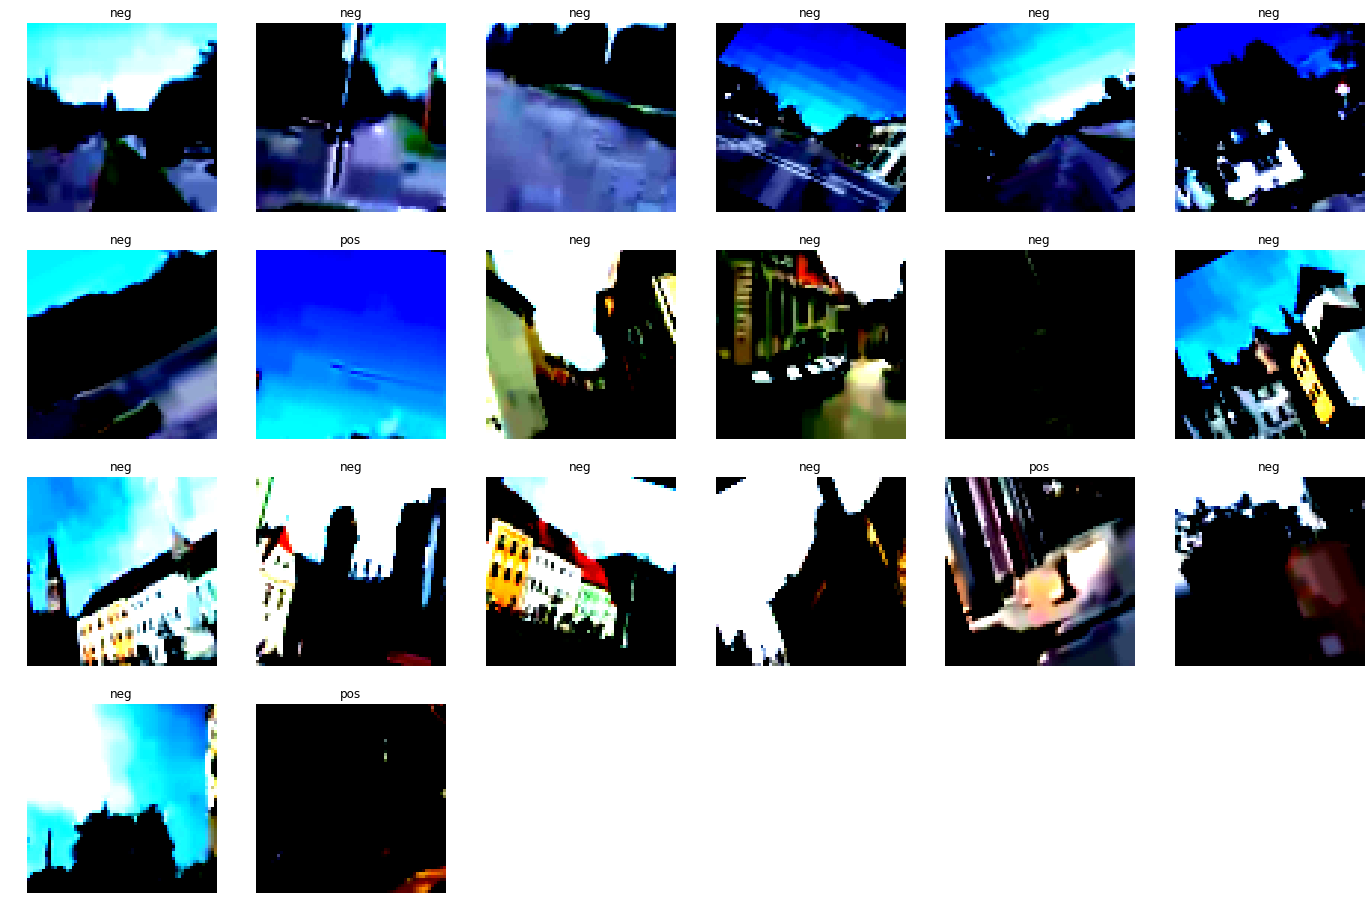

In [56]:
samples, _ = iter(test_load).next()

fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'neg', 1:'pos'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    
    plt.imshow(np.transpose(sample, (1,2,0)))